
# 🧠 Human-Level Performance, Avoidable Bias & Surpassing Human Performance  
## Лабораторная работа / Laboratory Assignment

**Course:** ML Intro  
**Runtime:** ~20–30 min on Colab GPU  

---

### 🇷🇺 Описание
Вы изучите, как сравнение модели с человеком помогает анализировать ошибки и улучшать качество модели.  
Будем вычислять **avoidable bias** и **variance**, а также рассуждать о достижении и превышении уровня человека.

### 🇬🇧 Description
You will learn how comparing a model to human performance helps analyze errors and improve model quality.  
We will compute **avoidable bias** and **variance**, and discuss reaching and surpassing the human-level benchmark.



## 🎯 Цели / Goals

| 🇷🇺 Цель | 🇬🇧 Goal |
|---|---|
| Понять разницу между bias и variance. | Understand the difference between bias and variance. |
| Оценивать avoidable bias относительно человека. | Compute avoidable bias relative to a human benchmark. |
| Провести mini-optimization для улучшения Dev/Test. | Perform a small optimization to improve Dev/Test. |
| Осознать, когда модель превосходит человека и что это значит. | Reflect on what it means to surpass human-level performance. |



## 📋 Что нужно сделать / What to Do

1️⃣ **Student Info:** заполните имя, группу.  
2️⃣ **Data:** подготовьте Train/Dev/Test и лоадеры.  
3️⃣ **Model:** реализуйте CNN и `evaluate`.  
4️⃣ **Baseline:** обучите, посчитайте Train/Dev/Test, bias/variance.  
5️⃣ **Visualization:** постройте график Human vs Train/Dev/Test.  
6️⃣ **Hyperparam Search:** реализация поиска `lr × weight_decay`.  
7️⃣ **Post-opt Bias/Variance:** расчёт после оптимизации.  
8️⃣ **Reflection:** ответьте на 3 вопроса.  
9️⃣ **Auto-Grader & Export:** получите счёт и JSON.


In [1]:

# @title 1) Student Info & Config
# All code comments are in English.


# === ОБЯЗАТЕЛЬНО ЗАПОЛНИТЬ ===
full_name = "Doe John"     # например: "Тощев Александр"
student_group = "11-111"      # например: "208"
assignment_id = "HLP_AvoidableBias"
assert full_name != "Фамилия Имя", "Заполните full_name"
assert student_group != "Группа", "Заполните student_group"
print("✔ Student Info OK")

# Typical human accuracy (benchmark) for MNIST may be ~97-99%.
HUMAN_ACCURACY = 98.0  # @param {type:"number"}

print("Student:", full_name)
print("Human reference accuracy (%):", HUMAN_ACCURACY)


✔ Student Info OK
Student: Doe John
Human reference accuracy (%): 98.0


In [2]:

from datetime import datetime, timezone, timedelta

# Установите окна приёма (пример):

start_at_iso = "2025-10-06T09:00-04:00"  #@param {type:"string"}
due_at_iso   = "2025-10-20T23:59-04:00"  #@param {type:"string"}
start_dt = datetime.fromisoformat(start_at_iso)
due_dt   = datetime.fromisoformat(due_at_iso)
# Для протокола: время сдачи берём текущее (можно заменить на mtime файла)
import os
from datetime import datetime, timezone

# 📅 Add submission date based on file modification time
try:
    nb_path = __file__ if "__file__" in globals() else "HLP_AvoidableBias_Assignment_RU_EN.ipynb"
    mtime = os.path.getmtime(nb_path)
    submission_dt = datetime.fromtimestamp(mtime, tz=timezone.utc)
except Exception:
    submission_dt = datetime.utcnow().replace(tzinfo=timezone.utc)

def penalty_fraction(start_dt, due_dt, submission_dt):
    """Возвращает долю штрафа [0..1].
    0 — без штрафа (<= due_dt). Линейно растёт от due_dt к due_dt + (due_dt - start_dt).
    Не выходит за 1.0.
    """
    if submission_dt <= due_dt:
        return 0.0
    total = (due_dt - start_dt).total_seconds()
    late  = (submission_dt - due_dt).total_seconds()
    if total <= 0:
        return 1.0 if late > 0 else 0.0
    return min(1.0, max(0.0, late / total))

print(f"Окно приёма: {start_dt.isoformat()} — {due_dt.isoformat()} (UTC)")
print(f"Время сдачи: {submission_dt.isoformat()} (UTC)")

Окно приёма: 2025-10-06T09:00:00-04:00 — 2025-10-20T23:59:00-04:00 (UTC)
Время сдачи: 2025-10-06T11:12:47.399253+00:00 (UTC)



## 2) ⚙️ Setup & Imports

**🇷🇺** Установки (при необходимости) и импорты.  
**🇬🇧** Installs (if needed) and imports.


In [3]:

# @title 2) Setup & Imports
# If running on Colab, most are preinstalled. Uncomment if needed.
# !pip install -q torch torchvision torchaudio scikit-learn matplotlib

import os, math, time, random, json
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

print("Torch:", torch.__version__, "| CUDA:", torch.cuda.is_available(), "| Device:", DEVICE)


Torch: 2.7.1+cu126 | CUDA: True | Device: cuda



## 3) 🧩 Assignment: Prepare Dataset (Train/Dev/Test)

**🇷🇺 Что нужно сделать:**  
Загрузите **MNIST**, разделите обучающую часть на **Train (50k)** и **Dev (10k)**,  
создайте три `DataLoader`: `train_loader`, `dev_loader`, `test_loader`. Используйте `batch_size = 128`.

**🇬🇧 What to do:**  
Load **MNIST**, split the training set into **Train (50k)** and **Dev (10k)**,  
create `train_loader`, `dev_loader`, `test_loader`. Use `batch_size = 128`.


In [4]:

# @title 3) YOUR CODE HERE — Data setup
# Common transform (grayscale → tensor)
transform = T.Compose([T.ToTensor()])

# ==== YOUR CODE HERE ====
# 1) Load MNIST train_full and test_ds
train_full =   # YOUR CODE HERE
test_ds    =   # YOUR CODE HERE

# 2) Split train_full into train_ds (50k) and dev_ds (10k)
train_size = 50_000
dev_size   = len(train_full) - train_size
train_ds, dev_ds = random_split(
    train_full, [train_size, dev_size],
    generator=torch.Generator().manual_seed(SEED)  
)

# 3) Create DataLoaders
BATCH = 128 
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)   # YOUR CODE HERE
dev_loader   = DataLoader(dev_ds,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)   # YOUR CODE HERE
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)   # YOUR CODE HERE

completed_data = True
print("✅ Data ready:", len(train_ds), len(dev_ds), len(test_ds))


✅ Data ready: 50000 10000 10000



## 4) 🧩 Assignment: Build the Model (CNN)

**🇷🇺 Что нужно сделать:**  
Реализуйте простую CNN:  
Conv(1→16)  → Conv(16→32) → Pool → FC(32×7×7→128) → FC(128→10).  
Создайте хелпер `evaluate(model, loader)` для подсчёта accuracy.

**🇬🇧 What to do:**  
Implement a small CNN:  
Conv(1→16) → Conv(16→32) → Pool → FC(32×7×7→128) → FC(128→10).  
Define an `evaluate(model, loader)` helper to compute accuracy.


In [5]:

# @title 4) YOUR CODE HERE — CNN model
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== YOUR CODE HERE ====
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 =    # YOUR CODE HERE
        self.conv2 =   # YOUR CODE HERE
        self.pool  =                 # YOUR CODE HERE
        self.fc1   =           # YOUR CODE HERE
        self.fc2   =                # YOUR CODE HERE

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 1x28x28 -> 16x14x14
        x = self.pool(F.relu(self.conv2(x)))  # 16x14x14 -> 32x7x7
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def evaluate(model, loader, device=DEVICE):
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(yb.cpu().numpy())
    return 100.0 * accuracy_score(y_true, y_pred)

completed_model = True
print("✅ Model defined.")


✅ Model defined.



## 5) 🧩 Assignment: Train Baseline & Compute Bias/Variance

**🇷🇺 Что нужно сделать:**  
1) Обучите `SmallCNN` на Train (3 эпохи),  
2) Получите точности на Train/Dev/Test,  
3) Рассчитайте: `avoidable_bias = HUMAN_ACCURACY - train_acc`, `variance = dev_acc - train_acc`.

**🇬🇧 What to do:**  
1) Train `SmallCNN` on Train (3 epochs),  
2) Compute Train/Dev/Test accuracies,  
3) Calculate: `avoidable_bias = HUMAN_ACCURACY - train_acc`, `variance = dev_acc - train_acc`.


In [6]:

# @title 5) YOUR CODE HERE — Train baseline & compute bias/variance
import torch.optim as optim

def train_one_epoch(model, loader, opt, device=DEVICE):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        loss.backward()
        opt.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

def train_model(epochs=3, lr=1e-3, weight_decay=0.0):
    # ==== YOUR CODE HERE ====
    model =
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_dev, best_state = -1.0, None
    for ep in range(1, epochs+1):
        loss = train_one_epoch(model, train_loader, opt)
        dv_acc = evaluate(model, dev_loader)
        if dv_acc > best_dev:
            best_dev = dv_acc
            best_state = {k:v.cpu() for k,v in model.state_dict().items()}
        print(f"Epoch {ep:02d} | loss={loss:.4f} | dev_acc={dv_acc:.2f}%")
    if best_state:
        model.load_state_dict({k:v.to(DEVICE) for k,v in best_state.items()})
    tr_acc = evaluate(model, train_loader)
    dv_acc = evaluate(model, dev_loader)
    ts_acc = evaluate(model, test_loader)
    return model, tr_acc, dv_acc, ts_acc

# ==== YOUR CODE HERE ====
BASELINE_EPOCHS = 
baseline_model, baseline_train_acc, baseline_dev_acc, baseline_test_acc = train_model(epochs=BASELINE_EPOCHS)

avoidable_bias =  # YOUR CODE HERE
variance       =   # YOUR CODE HERE

print(f"✅ Baseline done.\nTrain={baseline_train_acc:.2f}% Dev={baseline_dev_acc:.2f}% Test={baseline_test_acc:.2f}%")
print(f"Avoidable bias: {avoidable_bias:.2f} pp | Variance: {variance:.2f} pp")
completed_baseline = True


Epoch 01 | loss=0.3800 | dev_acc=95.91%
Epoch 02 | loss=0.0935 | dev_acc=97.80%
Epoch 03 | loss=0.0633 | dev_acc=98.03%
✅ Baseline done.
Train=98.47% Dev=98.03% Test=98.37%
Avoidable bias: 0.00 pp | Variance: 0.00 pp



## 6) 🧩 Assignment: Visualization

**🇷🇺 Что нужно сделать:**  
Постройте бар-график Human vs Train/Dev/Test. Добавьте краткий комментарий (markdown) из 1–2 предложений о разрыве и его смысле.

**🇬🇧 What to do:**  
Plot a bar chart Human vs Train/Dev/Test. Add a short (1–2 sentence) markdown comment on the gap and its meaning.


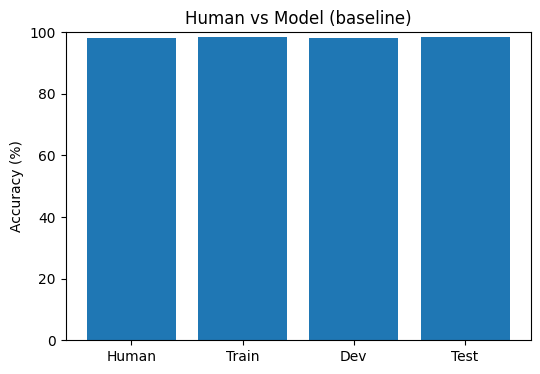

In [7]:

# @title 6) YOUR CODE HERE — Visualization
metrics = {
    "Human": HUMAN_ACCURACY,
    "Train": baseline_train_acc,
    "Dev":   baseline_dev_acc,
    "Test":  baseline_test_acc
}

# ==== YOUR CODE HERE ====
plt.figure(figsize=(6,4))
plt.bar(list(metrics.keys()), list(metrics.values()))  # YOUR CODE HERE
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title("Human vs Model (baseline)")
plt.show()

completed_viz = True



## 7) 🧩 Assignment: Implement Hyperparameter Search (lr × weight_decay)

**🇷🇺 Что нужно сделать:**  
Реализуйте перебор гиперпараметров `lr × weight_decay`, обучите модели и выберите лучшую по **Dev accuracy**.  
Сохраните все результаты в `student_search_results` и лучшую конфигурацию — в `student_best`.

**Требования:**  
- Перебрать каждую пару `(lr, weight_decay)`.  
- Для каждой пары обучить модель `epochs=SEARCH_EPOCHS`.  
- Сохранить для каждой пары: `{"lr","wd","train_acc","dev_acc","test_acc"}`.  
- Итог: `student_best = {"lr","wd","train_acc","dev_acc","test_acc"}` с максимальной `dev_acc`.

**🇬🇧 What to do:**  
Implement a grid over `lr × weight_decay`, train models, and pick the best by **Dev accuracy**.  
Store all runs in `student_search_results` and the winner in `student_best`.

**Requirements:**  
- Iterate over every `(lr, weight_decay)` pair.  
- Train for `epochs=SEARCH_EPOCHS` for each pair.  
- Save for each run: `{"lr","wd","train_acc","dev_acc","test_acc"}`.  
- Final: `student_best = {"lr","wd","train_acc","dev_acc","test_acc"}` with the highest `dev_acc`.


In [ ]:

# @title 7) YOUR CODE HERE — Hyperparameter Search (grid over lr × weight_decay)
# Hints:
# - Reuse train_model(epochs=..., lr=..., weight_decay=...) defined above.
# - Keep student_search_results (list of dicts) and student_best (dict).

# Suggested search space (you may adjust but keep it Colab-friendly):
SEARCH_EPOCHS =   # @param {type:"number"}  # small for speed; can increase on GPU
LRS = []  # @param
WDS = []   # @param

# Containers the grader will look for:
student_search_results = []  # list of dicts
student_best = None          # dict with keys: lr, wd, train_acc, dev_acc, test_acc

# ==== YOUR CODE HERE ====
for lr in LRS:
    for wd in WDS:
        model, tr_acc, dv_acc, ts_acc =  # YOUR CODE HERE
        run = {"lr": lr, "wd": wd, "train_acc": tr_acc, "dev_acc": dv_acc, "test_acc": ts_acc}
        student_search_results.append(run)
        if (student_best is None) or (dv_acc > student_best["dev_acc"]):
            student_best =   # YOUR CODE HERE

print(f"Total runs: {len(student_search_results)}")
print("Top by Dev:", student_best)



## 8) 🧩 Assignment: Bias/Variance *after* Optimization

**🇷🇺 Что нужно сделать:**  
Используя `student_best`, пересчитайте **avoidable bias** и **variance**, визуализируйте Human vs Train*/Dev*/Test*.

**🇬🇧 What to do:**  
Using `student_best`, recompute **avoidable bias** and **variance**, and visualize Human vs Train*/Dev*/Test*.


After optimization -> Dev: 98.62% | Test: 98.76%
Avoidable bias: 0.00 pp | Variance: 0.00 pp


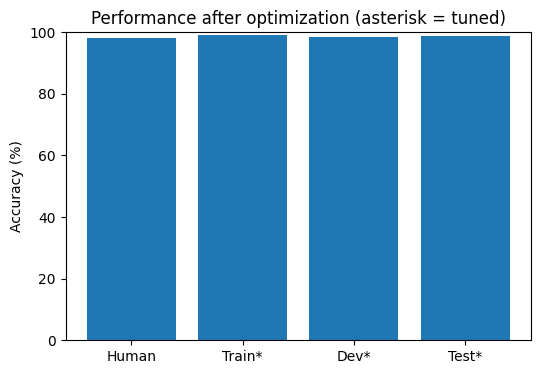

In [9]:

# @title 8) YOUR CODE HERE — Post-optimization bias/variance
if student_best is None:
    raise RuntimeError("student_best is None. Please complete the hyperparameter search cell first.")

# ==== YOUR CODE HERE ====
opt_avoidable_bias =   # YOUR CODE HERE
opt_variance       =   # YOUR CODE HERE

print(f"After optimization -> Dev: {student_best['dev_acc']:.2f}% | Test: {student_best['test_acc']:.2f}%")
print(f"Avoidable bias: {opt_avoidable_bias:.2f} pp | Variance: {opt_variance:.2f} pp")

plt.figure(figsize=(6,4))
plt.bar(["Human","Train*","Dev*","Test*"],
        [HUMAN_ACCURACY, student_best["train_acc"], student_best["dev_acc"], student_best["test_acc"]])  # YOUR CODE HERE
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title("Performance after optimization (asterisk = tuned)")
plt.show()



## 9) 🧩 Assignment: Reflection (RU/EN)

**🇷🇺 Напишите короткие ответы (≥ 2–3 предложения на пункт):**  
1) Почему после превышения уровня человека **human-level** перестаёт быть потолком?  
2) Почему человеческий уровень — не конечный предел?  
3) Примеры систем, превзошедших человека и почему.

**🇬🇧 Write short answers (≥ 2–3 sentences each):**  
1) Why does *human-level* stop being a ceiling once surpassed?  
2) Why is human performance not the final limit?  
3) Examples of systems surpassing humans and why.


In [10]:

# @title 9) YOUR CODE HERE — Reflection (edit the strings)
REFLECTION = {
    # ==== YOUR CODE HERE ====
    "when_surpass_human_stop_using_human_as_ceiling": "YOUR ANSWER HERE",
    "why_human_not_final_limit": "YOUR ANSWER HERE",
    "examples_surpassing_human": "YOUR ANSWER HERE"
}
print("Reflection answers recorded.")
completed_reflection = True


Reflection answers recorded.



## 10) ✅ Auto-Graders (checks all assignments)

**🇷🇺** Автопроверка проверяет: Data, Model, Baseline, Bias/Variance, Visualization, Поиск гиперпараметров, Улучшение/достижение уровня человека, Reflection.  
**🇬🇧** The grader checks: Data, Model, Baseline, Bias/Variance, Visualization, Hyperparam Search, Improvement/Human-level, Reflection.


In [12]:

# @title 10) Auto-Graders (checks all assignments)
from datetime import datetime

def _nonempty_str(x): 
    return isinstance(x, str) and len(x.strip()) >= 10

SCORES = {
    "data_ok": 0,
    "model_ok": 0,
    "baseline_ok": 0,
    "biasvar_ok": 0,
    "viz_ok": 0,
    "search_ok": 0,
    "improvement_or_human": 0,
    "reflection_ok": 0
}

# 1) Data loaders present
try:
    assert completed_data
    for obj in [train_loader, dev_loader, test_loader]:
        assert obj is not None
    SCORES["data_ok"] = 1
except Exception as e:
    print("[grader] Data section incomplete:", e)

# 2) Model present
try:
    assert completed_model
    m = SmallCNN().to(DEVICE)
    assert hasattr(m, "fc2")
    SCORES["model_ok"] = 1
except Exception as e:
    print("[grader] Model section incomplete:", e)

# 3) Baseline trained
try:
    assert completed_baseline
    assert isinstance(baseline_train_acc, float) and isinstance(baseline_dev_acc, float) and isinstance(baseline_test_acc, float)
    SCORES["baseline_ok"] = 1
except Exception as e:
    print("[grader] Baseline training incomplete:", e)

# 4) Bias/Variance computed (baseline)
try:
    assert isinstance(avoidable_bias, float) and isinstance(variance, float)
    SCORES["biasvar_ok"] = 1
except Exception as e:
    print("[grader] Bias/Variance not computed:", e)

# 5) Visualization done (soft check)
try:
    assert completed_viz
    SCORES["viz_ok"] = 1
except Exception as e:
    print("[grader] Visualization missing:", e)

# 6) Search implemented
try:
    assert isinstance(student_search_results, list) and len(student_search_results) >= 1
    assert isinstance(student_best, dict)
    for key in ["lr","wd","train_acc","dev_acc","test_acc"]:
        assert key in student_best
    SCORES["search_ok"] = 1
except Exception as e:
    print("[grader] Search implementation incomplete:", e)

# 7) Improvement ≥ +2pp or reach human on Dev
try:
    improved = (float(student_best["dev_acc"]) - float(baseline_dev_acc)) >= 2.0
    reached_human = float(student_best["dev_acc"]) >= float(HUMAN_ACCURACY)
    if improved or reached_human:
        SCORES["improvement_or_human"] = 1
    else:
        print(f"[grader] Need +2pp improvement or >= human. Baseline Dev={baseline_dev_acc:.2f}, best Dev={student_best['dev_acc']:.2f}.")
except Exception as e:
    print("[grader] Improvement check failed:", e)

# 8) Reflection
try:
    ok = all(k in REFLECTION and _nonempty_str(REFLECTION[k]) for k in [
        "when_surpass_human_stop_using_human_as_ceiling",
        "why_human_not_final_limit",
        "examples_surpassing_human"
    ])
    if ok:
        SCORES["reflection_ok"] = 1
    else:
        print("[grader] Reflection fields are empty or too short.")
except Exception as e:
    print("[grader] Reflection check failed:", e)

total = sum(SCORES.values())
MAX = len(SCORES)





## 11) 📤 Export Helpers

**🇷🇺** Сохраните JSON одной строкой — удобно загружать в LMS/Drive.  
**🇬🇧** Save the one-line JSON result — convenient for LMS/Drive uploads.



### Extra A) Error Analysis
**RU:** Выведите 12–16 неверных предсказаний Dev и обсудите паттерны.  
**EN:** Show 12–16 wrong Dev predictions and discuss patterns.


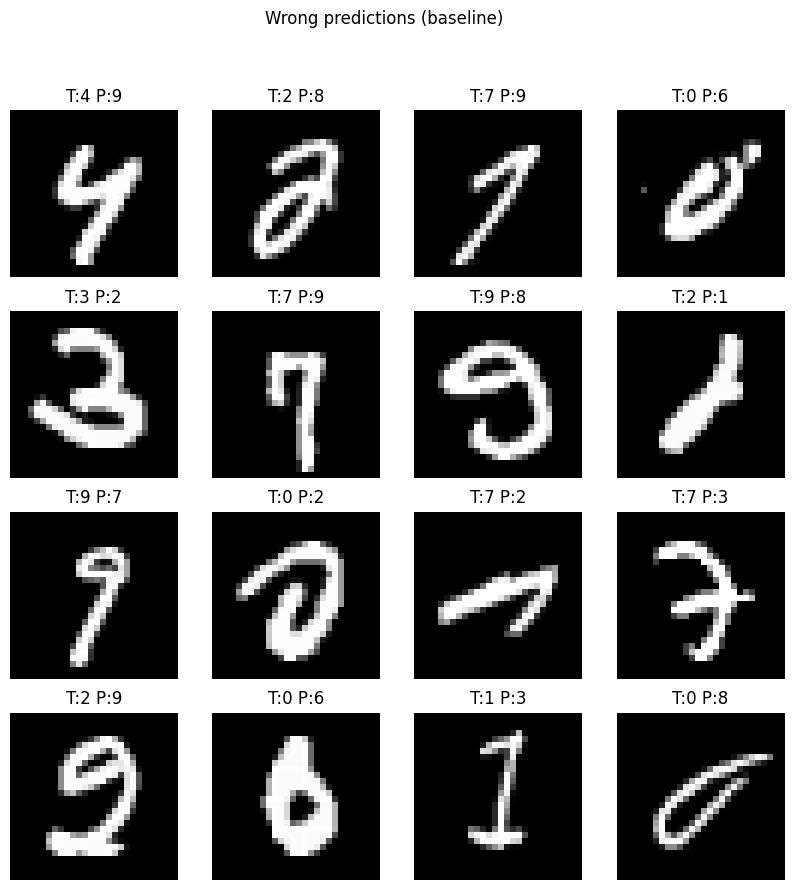

In [13]:

# @title Extra A) Error Analysis (show wrong predictions)
def collect_wrong_preds(model, loader, max_items=16):
    model.eval()
    wrong = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1)
            mask = preds != yb
            idxs = torch.where(mask)[0]
            for i in idxs:
                wrong.append((xb[i].cpu(), int(yb[i].cpu()), int(preds[i].cpu())))
                if len(wrong) >= max_items:
                    return wrong
    return wrong

wrong = collect_wrong_preds(baseline_model, dev_loader, max_items=16)
cols = 4
rows = max(1, math.ceil(len(wrong)/cols))
plt.figure(figsize=(10, 2.5*rows))
for i, item in enumerate(wrong):
    img, y_true, y_pred = item
    plt.subplot(rows, cols, i+1)
    plt.imshow(img.squeeze(0), cmap="gray")
    plt.title(f"T:{y_true} P:{y_pred}")
    plt.axis("off")
plt.suptitle("Wrong predictions (baseline)")
plt.show()



### Extra B) Simple Augmentation
**RU:** Попробуйте лёгкие аугментации (`RandomRotation`) и сравните метрики.  
**EN:** Try light augmentation (`RandomRotation`) and compare metrics.


In [14]:

# @title Extra B) Simple Augmentation (try & compare)
aug_transform = T.Compose([T.RandomRotation(10), T.ToTensor()])
train_full_aug = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=aug_transform)
train_ds_aug, _ = random_split(train_full_aug, [50_000, len(train_full_aug)-50_000],
                               generator=torch.Generator().manual_seed(SEED))
train_loader_aug = DataLoader(train_ds_aug, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)

def train_model_with_loader(train_loader, epochs=3, lr=1e-3, weight_decay=0.0):
    model = SmallCNN().to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_dev = -1.0
    best_state = None
    for ep in range(1, epochs+1):
        train_one_epoch(model, train_loader, opt)
        dv = evaluate(model, dev_loader)
        if dv > best_dev:
            best_dev = dv
            best_state = {k:v.cpu() for k,v in model.state_dict().items()}
        print(f"[AUG] Epoch {ep:02d} | dev_acc={dv:.2f}%")
    model.load_state_dict({k:v.to(DEVICE) for k,v in best_state.items()})
    return model, evaluate(model, train_loader), evaluate(model, dev_loader), evaluate(model, test_loader)

aug_model, aug_tr, aug_dv, aug_ts = train_model_with_loader(train_loader_aug, epochs=3, lr=1e-3, weight_decay=0.0)
print(f"\nAugmented => Train:{aug_tr:.2f}% Dev:{aug_dv:.2f}% Test:{aug_ts:.2f}%")
print("Compare with baseline -> Dev:{:.2f}% Test:{:.2f}%".format(baseline_dev_acc, baseline_test_acc))


[AUG] Epoch 01 | dev_acc=96.46%
[AUG] Epoch 02 | dev_acc=97.69%
[AUG] Epoch 03 | dev_acc=98.14%

Augmented => Train:97.95% Dev:98.14% Test:98.44%
Compare with baseline -> Dev:98.03% Test:98.37%


In [15]:

import json

# применяем штраф
try:
    pf = penalty_fraction(start_dt, due_dt, submission_dt)
except NameError:
    from datetime import timezone
    pf = 0.0
# ✅ Итоговый результат
total = sum(SCORES.values())
MAX =  len(SCORES)
max_points = 100

raw_score = round(100.0 * total / MAX)
final_score = max(0.0, raw_score * (1.0 - min(1.0, pf)))

print(f"Сырой балл: {raw_score}/{max_points}")
print(f"Штраф (доля): {pf:.4f}")
print(f"Итоговый балл после штрафа: {final_score:.2f}/{max_points}")

# Последняя строка — JSON, который читает harness
final = {
    "name": full_name,
    "group": student_group,
    "assignment": assignment_id,
    "score": float(final_score)
}




Сырой балл: 100/100
Штраф (доля): 0.0000
Итоговый балл после штрафа: 100.00/100
{"name": "Doe John", "group": "11-111", "assignment": "HLP_AvoidableBias", "score": 100.0}


In [16]:
print(json.dumps(final, ensure_ascii=False))

{"name": "Doe John", "group": "11-111", "assignment": "HLP_AvoidableBias", "score": 100.0}
